In [ ]:
#install necessary packages
%pip install scikit-learn --upgrade
%pip install imblearn

In [1]:
#import basic functions and set up functions used throughout notebook. 

import os
from google.colab import drive
drive.mount('/content/drive')
#change this throughout to reflect your appropriate working directory
%cd '/content/drive/MyDrive/cook_adjacency_working/'

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from functools import reduce
import glob
import networkx as nx
import re


def brittin_layers(n):
  #requires passing nclass first
  if n in ('CEPV', 'URY', 'URA', 'URA', 'RME', 'RIP', 'OLQ', 'IL2', 'IL1', 
           'URY', 'IL1', 'RMDD', 'RMDV', 'OLL', 'RIH', 'AVE', 'RIA'
  ):
    return 'Anterior'
  if n in ('FLP', 'ADA', 'ASH', 'RIF', 'PVP', 'PVC', 'BDU', 'AVM', 'AVJ', 'AVH', 'AVD', 'AVB', 'ALM', 'AQR'
  ):
    return 'Avoidance'
  if n in ('DVC', 'RIG', 'RIS', 'SMD', 'RIV', 'SAA', 'PVT', 'AVK', 'AVL', 'RMF', 'RIM'
  ):
    return 'Lateral'
  if n in ('RMG', 'CEPD', 'URB', 'DVA', 'SMB', 'SIA', 'SIBV', 'SIBD', 'RIC', 'SDQ', 'RMH'
  ):
    return 'Sublateral'
  if n in ('BAG', 'RIB', 'ASI', 'AWC', 'AIN', 'AUA', 'AFD', 'AIY', 'ADL', 'AWB', 'ASE', 'AWA', 'ADF', 'AIZ', 'AIB', 'AIA', 'ASG', 'ASK', 'AVF', 'PVQ', 'ASJ', 'AIM', 'ALA'
  ):
    return 'Taxis'
  if n in ('RMD', 'URX', 'ALN', 'ADE', 'AVA', 'RIR', 'RID', 'HSN', 'PVR', 'PVN', 'PLN'
  ):
    return 'Unclassified'
  else:
    return 'non-ganglia'


def moyle_layers(n):
  if n in ('CEPV', 'CEPD', 'IL1', 'IL2', 'OLL', 'OLQ', 'RIA', 'RIH', 'RIP', 'RMDV', 'RMDD', 'RME', 'URA', 'URB', 'URY'
  ):
    return 'Stratum1'
  if n in ('ADE', 'ALN', 'AVK', 'AVL', 'DVC', 'PLN', 'PVT', 'RIC', 'RIV', 'RMD', 'RMF', 'RMH', 'SAA', 'SIA', 'SIBD', 'SMB', 'SMD'
  ):
    return 'Stratum2'
  if n in ('ADA', 'ADL', 'AIM', 'ALA', 'ALM', 'AQR', 'ASH', 'ASJ', 'ASK', 'AVB', 'AVD', 'AVF', 'AVH', 'AVJ', 'AVM', 'BDU', 'DVA', 'HSN', 'PVC', 'PVN', 'PVP', 'PVQ', 'RID', 'RIF'
  ):
    return 'Stratum3'
  if n in ('ADF', 'AFD', 'AIA', 'AIN', 'AIY', 'ASE', 'ASG', 'ASI', 'AUA', 'AWB', 'AWC', 'BAG'
  ):
    return 'Stratum4'
  if n in ('AIB', 'AIZ', 'AVA', 'AVE', 'AWA', 'FLP', 'PVR', 'RIB', 'RIG', 'RIM', 'RIR', 'RIS', 'RMG', 'SDQ', 'SIBV', 'URX', 'VB0'
  ):
    return 'Unassigned'
  else:
    return 'non-ganglia'

def ganglia_check(i,j):
  if (i == 'non-ganglia') | (j == 'non-ganglia'):
     return '0'
  if i == j:
    return '1'
  else:
    return '2'

#nclass function originally published in Witvliet et al 2021, available on https://github.com/dwitvliet/nature2021

def nclass_strata(n):
  #deals with CEP,RMD,SIB to give 4 letter clasifications as per Moyle, Brittin, and ganglia differences
    if n in (
        'AVG', 'DVC', 'PVR', 'PVT', 'RIH', 'RIR', 'DVA', 'AQR', 'AVM', 'PQR',
        'PVM', 'DVB', 'PDA', 'PDB', 'ALA', 'AVL', 'RID', 'RIS',
        'I3', 'I4', 'I5', 'I5', 'M1', 'M4', 'M5', 'MI', 'BWM'
    ):
        return n
    if len(n) == 4 and n[-1] in 'LR' and n[:3] in (
        'ADA', 'ADE', 'ADF', 'ADL', 'AFD', 'AIA', 'AIB', 'AIM', 'AIN', 'AIY',
        'AIZ', 'ALM', 'ALN', 'ASE', 'ASG', 'ASH', 'ASI', 'ASJ', 'ASK', 'AUA',
        'AVA', 'AVB', 'AVD', 'AVE', 'AVF', 'AVH', 'AVJ', 'AVK', 'AWA', 'AWB',
        'AWC', 'BAG', 'BDU', 'CAN', 'FLP', 'GLR', 'HSN', 'IL1', 'IL2', 'LUA',
        'OLL', 'PDE', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PVC', 'PVD', 'PVN',
        'PVP', 'PVQ', 'PVW', 'RIA', 'RIB', 'RIC', 'RIF', 'RIG', 'RIM', 'RIP',
        'RIV', 'RMD', 'RMF', 'RMG', 'RMH', 'SDQ', 'URB', 'URX'
    ):
        return n[:3]
    if len(n) == 5 and n[-2:] in ('DL', 'DR', 'VL', 'VR') and n[:3] in (
        'GLR', 'IL1', 'IL2', 'OLQ', 'SAA', 'SIA', 'SMB',
        'SMD', 'URA', 'URY'
    ):
        return n[:3]
    if len(n) == 5 and n[-2:] in ('DL', 'DR', 'VL', 'VR') and n[:3] in (
        'CEP', 'RMD', 'SIB', 
 
    ):
        return n[:4]
    if len(n) == 8 and re.match('BWM-[DV][LR]0[0-8]', n):
        return 'BWM'
    if n in (
        'RMED', 'RMEL', 'RMER', 'RMEV', 'SABD', 'SABVL', 'SABVR',
    ):
        return n[:3]
    if n in (
        'CEPshDL', 'CEPshDR', 'CEPshVL', 'CEPshVR'
    ):
        return n[:5]
    if n[:2] in ('AS', 'VB', 'VA', 'VD') and n[2:] in map(str, range(12)):
        return n[:2]
    if n in ('VA12', 'VD12', 'VD13'):
        return n[:2]
    if re.match('^(DA[1-9])|(DB[1-7])|(DD[1-6])|(VC[1-6])$', n):
        return n[:2]
    else:
        return 'unk'
    return n

Mounted at /content/drive
/content/drive/MyDrive/cook_adjacency_working


Cell to create composite edge lists for adjacency and connectivity. Needs to be run separately for adjacency and connectivity.



In [ ]:
#DO NOT RUN UNLESS NEEDED TO COMPARE EDGE LISTS##


#compare edges script. takes formatted edge lists and compares conserved and discrepant edges based up on a set of all edges within files. will take every .csv file in the directory#

#declare arguments for how to run subsequent code. Grouped variable can either be class (takes first three letters) or a specific grouping. if directed is true then will treat edges as directed

#choose directory from which to work. folders separated by adjacency, synapses, adult.
DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency_working/input/male_full/inputs/'

GROUPED = 'class'

#if directed is true then will treat edges as directed

DIRECTED = False

#set weight threshold for edges

W = float(0)

#set whether to keep or remove muscles

MUSCLE = 'blank'


#take a list of .csv files, apply filters, compose a networkx graph for each.
os.chdir(DIRECTORY_CHOOSE)
csvfiles = []
csvfiles = [f for f in glob.glob('[!df"]*.csv')]
graphlist = []
for f in csvfiles:
	df = pd.read_csv(f, delimiter=',')
	df['weight'] = df['weight'].astype(float)
	if GROUPED == 'class':
		df['source']=df['source'].apply(str)
		df['target']=df['target'].apply(str)
		df['source'] = df.apply(lambda x: nclass_strata(x['source']), axis=1)
		df['target'] = df.apply(lambda x: nclass_strata(x['target']), axis=1)
		df = df.groupby(['source','target'], as_index=False)['weight'].sum()
	if DIRECTED != True:
		df[['source','target']] = np.sort(df[['source', 'target']])[:, ::1]
		df['weightyesno'] = np.where(df['weight'] > 0, 1, 0)
		df = df.groupby(['source','target'], as_index=False)['weight', 'weightyesno'].sum()
		df['reciprocal'] = np.where(df.weightyesno > 1, 'yes', 'no')
	if GROUPED != "class" and GROUPED != False:
		df = df[df.source.isin(eval(GROUPED))]
		df = df[df.target.isin(eval(GROUPED))]
		#df = df.groupby(['source','target'], as_index=False)['weight'].sum()
	if W > 0:
		df = df.drop(df[df.weight < W].index)
	if MUSCLE == 'remove':
		df = df[~df.source.str.contains('bwm', case=False)]
		df = df[~df.target.str.contains('bwm', case=False)]
	G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], create_using=nx.DiGraph())
	if DIRECTED != True:
		G.to_undirected(reciprocal=False, as_view=False)
	G.name = str(f)
	graphlist.append(G)

inter = nx.compose_all(graphlist)
	
#append a dataframe with all graphlists

for i in graphlist:
	i.name = str(i)[15:]
	Z = []
	for (e1,e2) in inter.edges():
		if i.has_edge(e1,e2):
			Z.append([e1,e2,i[e1][e2]['weight']])
		if not i.has_edge(e1,e2):
			Z.append([e1,e2,0])
	dfz = pd.DataFrame(Z)
	dfz.columns = ['pre', 'post', i.name + "_weight"]
	dfz.to_csv(i.name + '_pd.csv', index=False) 
	dataframes = []
set_array = []
for f in sorted(glob.glob("*_pd.csv")):
	dfa = pd.read_csv(f, sep=',')
	dataframes.append(dfa)
	os.remove(f)
		
		
#create new columns
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='outer'), dataframes)
df_merged["conserved"] = (df_merged.filter(like="weight",axis=1)!=0).sum(1)
df_merged["average_size"] = (df_merged.sum(axis=1) - df_merged.conserved) / df_merged.conserved

#write to csv
df_merged.to_csv("df_merged_adult_syn_male_DIRECTED.csv")



Main cell for generating model. Needs to be run before plotting.

In [2]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split

#recode function for how to deal with average synaptic size. 

def synapse_recode(X):
  if X > 0:
    return 1
  else:
    return 0

#import dfs from the compare syn and edge cell##
DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency_working/input/'
os.chdir(DIRECTORY_CHOOSE)
adj, syn = pd.read_csv('df_merged_adult_adj_ml_full.csv'), pd.read_csv('df_merged_adult_syn_ml_full.csv')
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), [adj,syn])
new_cols = ['jsh_adj', 'n2u_adj', 'witvliet_1_adj', 'witvliet_2_adj', 'witvliet_3_adj', 'witvliet_4_adj', 'witvliet_5_adj', 'witvliet_6_adj', 'witvliet_8_adj', 'jsh_syn', 'n2u_syn', 'witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'witvliet_7_syn', 'witvliet_8_syn']
df_merged.rename(columns=dict(zip(df_merged.columns[[3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24]], new_cols)),inplace=True)

#construct new columns to measure the average synaptic size. 
df_merged['new_ave_synapse'] = df_merged[['jsh_syn', 'n2u_syn', 'witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'witvliet_7_syn', 'witvliet_8_syn']].median(axis=1)
df_merged['dummy_size'] = df_merged['new_ave_synapse'].apply(synapse_recode)



#droplist includes SAB because Moyle and Brittin don't analyze. It's not a NR neuron. If a neuron is in one of two datasets, it becomes unclassified in the other.

droplist = ['unk', 'BWM', 'VA01', 'VB01', 'VB02', 'VC01', 'VD01', 'SAB', 'CAN', 'unknownFLPR', 'PVD', 'HSN', 'VA', 'VB', 'Fragment1', 'Fragment2', 'Fragment3', 'Fragment4', 'excgl', 'DB', 'DA', 'excduct']
df_merged = df_merged[~df_merged.pre.isin(droplist)]
df_merged = df_merged[~df_merged.post.isin(droplist)]


#scale and rename the adjacency columns
scaler = StandardScaler()
new_cols1 = ['jsh_adj-S', 'n2u_adj-S', 'witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'witvliet_8_adj-S']
df_scale = pd.DataFrame(scaler.fit_transform(df_merged.iloc[:,3:12]))
df_scale.rename(columns=dict(zip(df_scale.columns[[0,1,2,3,4,5,6,7,8]], new_cols1)),inplace=True)
df_scale['ave_scaled_adjacency'] = df_scale[['jsh_adj-S', 'n2u_adj-S', 'witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'witvliet_8_adj-S']].mean(axis=1)



#concatenate dfs
df_concat = pd.concat([df_merged, df_scale.set_index(df_merged.index)], axis=1)
df_concat['pre_brittin'] = df_concat.apply(lambda x: brittin_layers(x['pre']), axis=1)
df_concat['post_brittin'] = df_concat.apply(lambda x: brittin_layers(x['post']), axis=1)
df_concat['pre_moyle'] = df_concat.apply(lambda x: moyle_layers(x['pre']), axis=1)
df_concat['post_moyle'] = df_concat.apply(lambda x: moyle_layers(x['post']), axis=1)
df_concat['brittin_strata'] = df_concat.apply(lambda x: ganglia_check(x['pre_brittin'], x['post_brittin']), axis=1)
df_concat['moyle_strata'] = df_concat.apply(lambda x: ganglia_check(x['pre_moyle'], x['post_moyle']), axis=1)

#make dummy columns for the categorical predictors
categorical_cols = ['pre_brittin', 'post_brittin', 'pre_moyle', 'post_moyle', 'brittin_strata', 'moyle_strata']
df_concat[['brittin_bool_1', 'brittin_bool_2']] = pd.get_dummies(df_concat.brittin_strata, prefix='brittin')
df_concat[['moyle_bool_1', 'moyle_bool_2']] = pd.get_dummies(df_concat.moyle_strata, prefix='moyle')
df_concat[['moyle_bool_1', 'moyle_bool_2']] = pd.get_dummies(df_concat.moyle_strata, prefix='moyle')
df_concat[['brittin_pre_class_1', 'brittin_pre_class_2', 'brittin_pre_class_3', 'brittin_pre_class_4', 'brittin_pre_class_5', 'brittin_pre_class_6']] = pd.get_dummies(df_concat.pre_brittin, prefix='brittin')
df_concat[['brittin_post_class_1', 'brittin_post_class_2', 'brittin_post_class_3', 'brittin_post_class_4', 'brittin_post_class_5', 'brittin_post_class_6']] = pd.get_dummies(df_concat.post_brittin, prefix='moyle')
df_concat.fillna(0, inplace=True) 

df_concat.to_csv('/content/drive/MyDrive/cook_adjacency_working/figures/sup_1_NR_modeling.csv')
print('Number of adjacencies: ' + str(len(df_concat.index)))
print('Number of connections: ' + str(len(df_concat[df_concat['conserved_y'] >0])))



#set variables for modeling
X_scale= df_concat[['ave_scaled_adjacency', 'brittin_bool_1', 'brittin_bool_2']]
Y = df_concat.dummy_size
Y.fillna(0, inplace=True)
Y = Y.astype('int')

# Split 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.25,random_state=42)






Number of adjacencies: 2683
Number of connections: 1404


In [ ]:
###Cross validating the classifiers
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import svm
from matplotlib import pyplot as plt    
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate



mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=900,activation = 'logistic',solver='adam')
rf = RandomForestClassifier(n_estimators = 100, criterion='gini', verbose=0, random_state = np.random.RandomState(69), max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10)
x = XGBClassifier(eval_metric="auc", scale_pos_weight=25, early_stopping_rounds=10, enable_categorical=True, max_depth=9, min_child_weight=6, n_jobs = 8, n_estimators = 600, tree_method='exact', eta=0.5, verbosity = 0, learning_rate=0.0005, gamma=1.25, objective='reg:logistic', booster='dart')
clf = DecisionTreeClassifier(max_depth =5, random_state = 42, min_samples_leaf=5)
logreg = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
classifiers = [mlp, rf, x, clf, logreg]
names = ['Multi-layer Perceptron', 'Random Forest', 'XGBoost', 'Decision Tree', 'Logistic Regression']

smote_nc = SMOTENC(categorical_features=[1,2], random_state=1)
scores = {}
i = 0
for j in classifiers:
    pip = make_pipeline(smote_nc, j)
    cv = StratifiedKFold(n_splits=10)
    metrics = cross_validate(pip, X_train, y_train, scoring=('average_precision','roc_auc','f1'), cv=cv, return_train_score=True)
    roc = metrics['test_roc_auc']
    avg_precision = metrics['test_average_precision']
    f1 = metrics['test_f1']
    scores[names[i]] = [np.mean(roc), np.mean(avg_precision), np.mean(f1)]
    i += 1
scoresdf = pd.DataFrame.from_dict(scores)
scoresdf = scoresdf.set_index(pd.Index(['ROC_AUC', 'PR_AUC','F1'], name='Metric'))
scoresdf.to_csv('/content/drive/MyDrive/cook_adjacency_working/figures/Table1_model_scores.csv')
scoresdf


,Multi-layer Perceptron,Random Forest,XGBoost,Decision Tree,Logistic Regression
Metric,,,,,
ROC_AUC,0.937864,0.904719,0.915541,0.923959,0.937307
PR_AUC,0.791543,0.698312,0.653441,0.703208,0.790901
F1,0.706490,0.677466,0.537986,0.709319,0.730453


In [ ]:
#hyperparameter tuning of logistic regression
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
#smote original training split including categorical
smote_nc = SMOTENC(categorical_features=[1,2], random_state=60)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)




# smotedf = shuffle(smotedf, random_state=1)

#import GridseachCV
from sklearn.model_selection import GridSearchCV

#Instantiate
clf = LogisticRegression()

#Grid
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 2, 10, 100, 1000], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#Gridsearch
gridsearch = GridSearchCV(clf, parameter_grid)
gridsearch.fit(X_train_smote, y_train_smote);

#Get best hyperparameters
gridsearch.best_params_

Final statistics and plotting cell

filling fraction is 0.5232948192322028
[0.19585112873703478, 0.23664596273291927, 0.24180581323438466, 0.2413793103448276, 0.2918945798110393, 0.2966804979253112, 0.3659454374412041, 0.3957858769931663, 0.46373951652688705]
spearman's r for conserved_x and conserved_y 0.5788705167322703 6.879039522037795e-240
spearman's r for conserved_x and new_ave_synapse 0.4337401347440604 1.6447842377917217e-123
spearman's r for ave scaled adjacency and new_ave_synapse 0.6159480486206614 4.673346098883832e-280
pearson's r for ave scaled adjacency and new_ave_synapse 0.6821035059283624 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

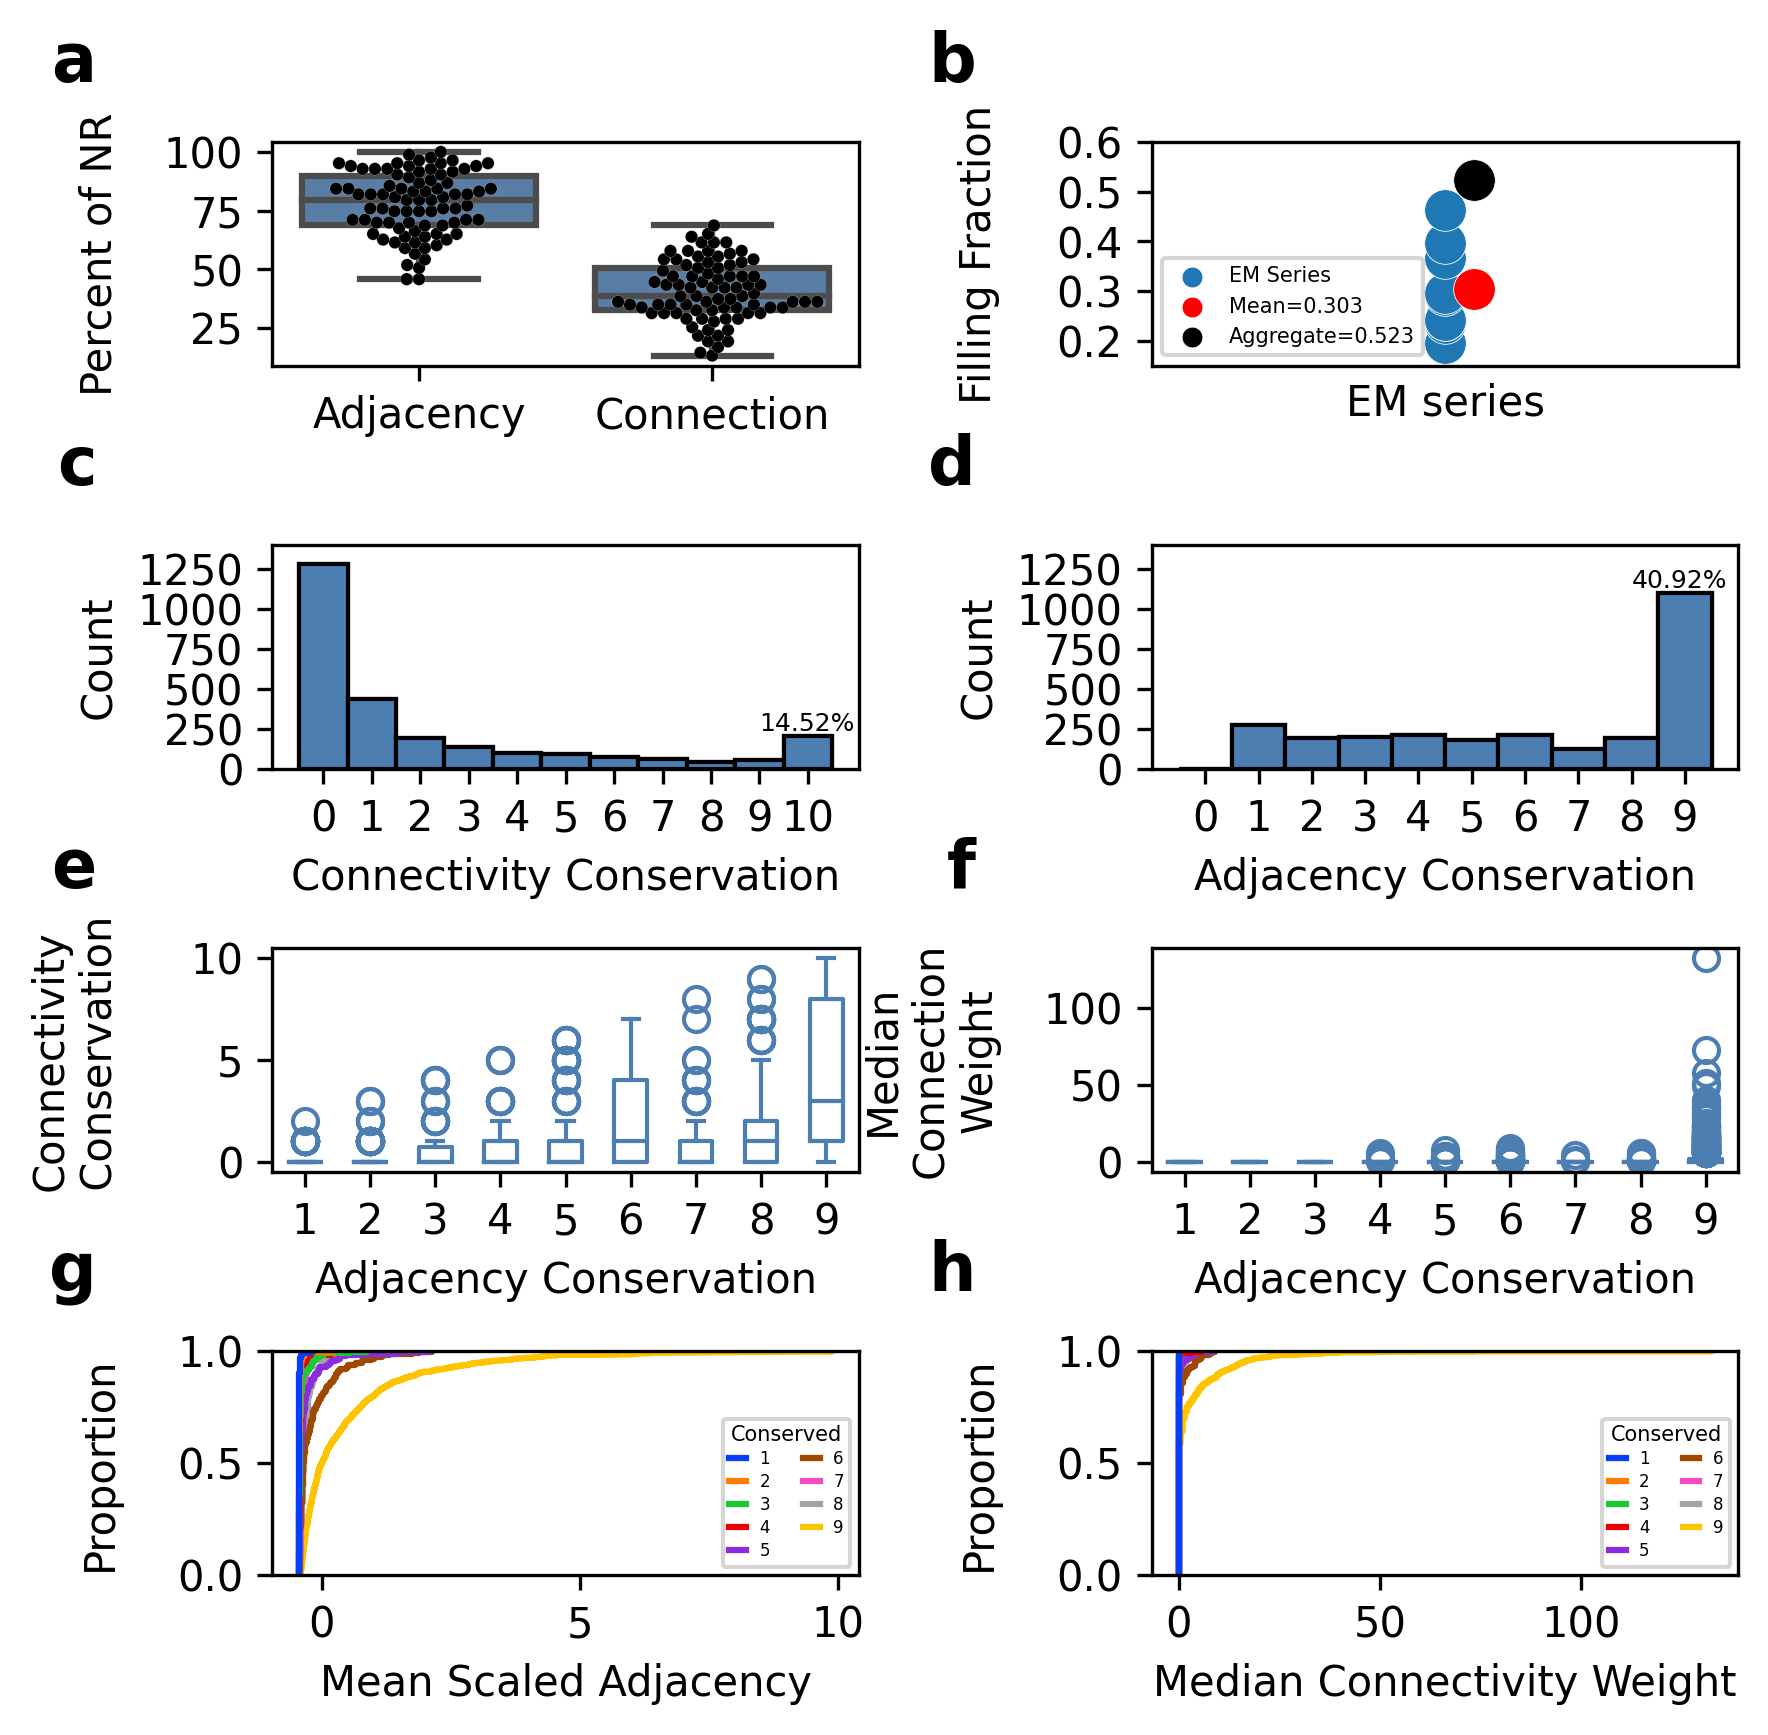

<Figure size 432x288 with 0 Axes>

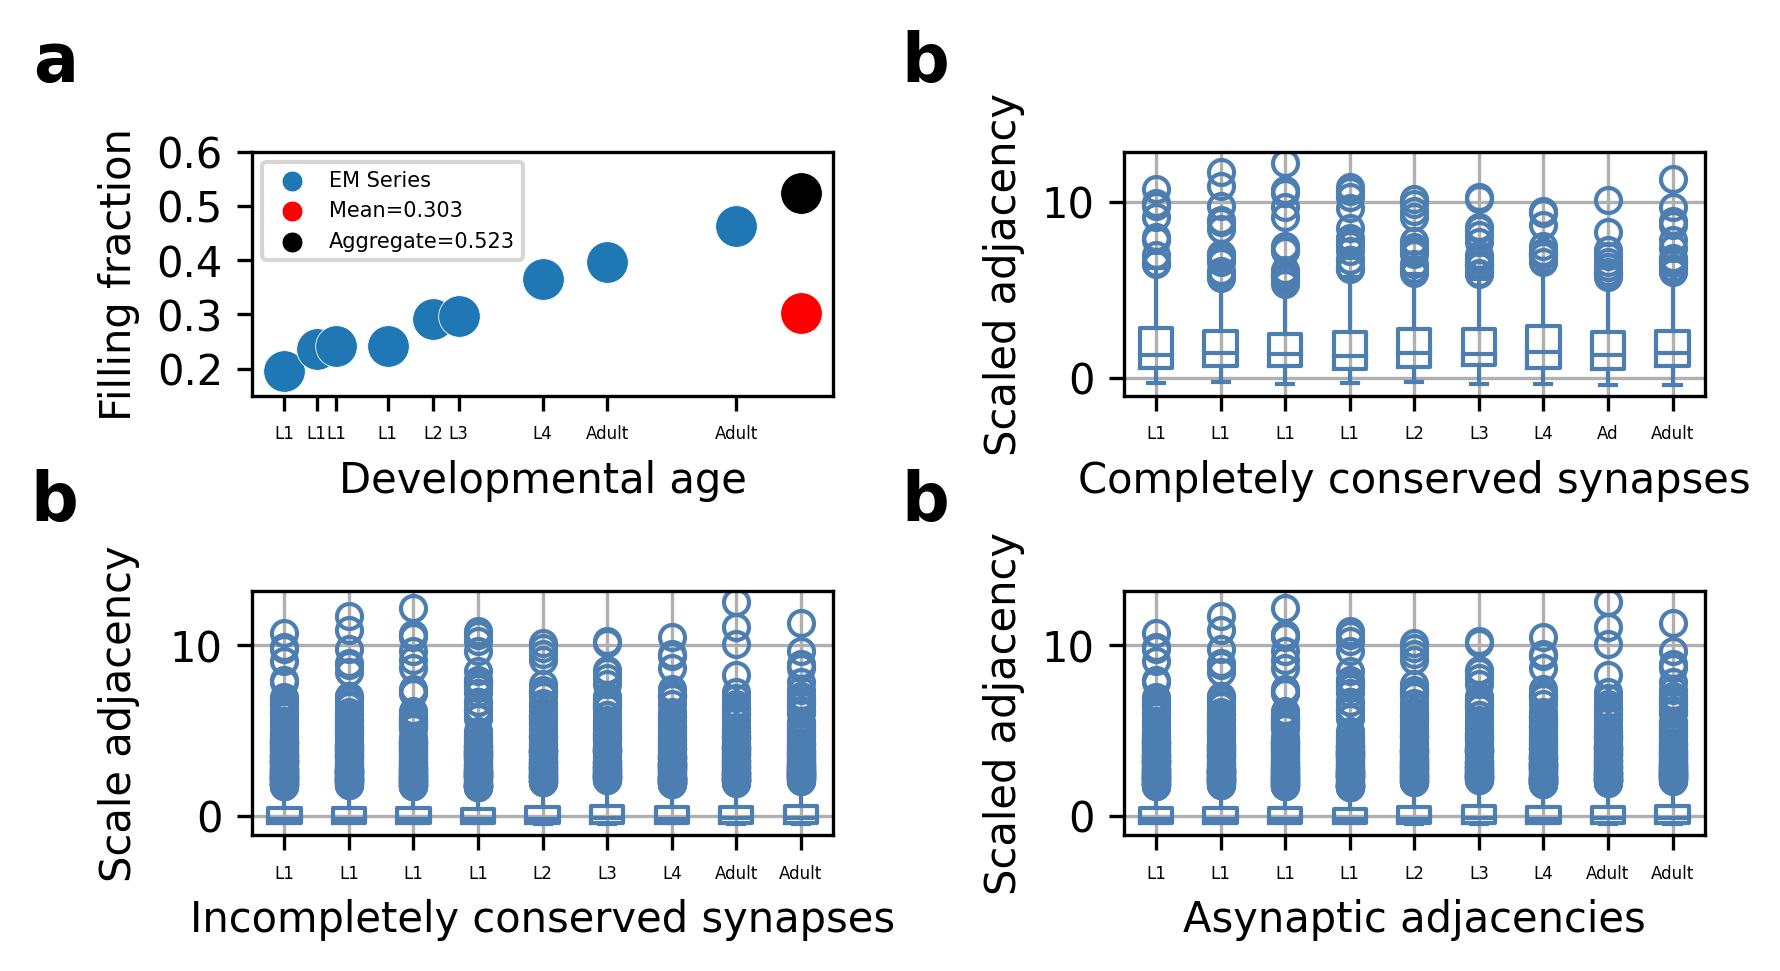

In [4]:
from itertools import product
import matplotlib.colors
from scipy import stats
from scipy.special import expit
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt





print('logistic_regression')

logreg_final = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
logreg_final.fit(X_train_smote, y_train_smote)
log_predictions = logreg_final.predict(X_test)
print(classification_report(y_test,log_predictions))



y_pred_proba = logreg_final.predict_proba(X_test)[::,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)
auc_ROC = str(metrics.roc_auc_score(y_test, y_pred_proba))[:5]
auc_precision_recall = str(metrics.auc(recall, precision))[:5]
print("ROC-AUC is", auc_ROC)
print("PR-AUC is", auc_precision_recall)
print('intercept:', logreg_final.intercept_)
print('coefficient:', logreg_final.coef_[0])






###calculate statistics###

##Filling Fraction Section####
filling_fraction = len(df_concat[df_concat.conserved_y > 0]) / len(df_concat.conserved_y)
filling_fraction_str = str(len(df_concat[df_concat.conserved_y > 0]) / len(df_concat.conserved_y))[:5]

print("filling fraction is", filling_fraction)


ff_list =  ['witvliet_1', 'witvliet_2', 'witvliet_3', 'witvliet_4', 'witvliet_5', 'witvliet_6', 'witvliet_8', 'jsh', 'n2u']

ff_values = []
for i in ff_list:
  syn_col = (i + '_syn')
  adj_col = (i + '_adj')
  value = len(df_concat[df_concat[syn_col] > 0]) / len(df_concat[df_concat[adj_col] > 0])
  ff_values.append(value)

print(ff_values)
ff_mean = str(np.mean(ff_values))[:5]
  


###correlations###
rho, pval = stats.spearmanr(df_concat.conserved_x, df_concat.conserved_y)
print("spearman's r for conserved_x and conserved_y", rho, pval)

rho, pval = stats.spearmanr(df_concat.conserved_x, df_concat.new_ave_synapse)
print("spearman's r for conserved_x and new_ave_synapse", rho, pval)

rho, pval = stats.spearmanr(df_concat.ave_scaled_adjacency, df_concat.new_ave_synapse)
print("spearman's r for ave scaled adjacency and new_ave_synapse", rho, pval)

rho, pval = stats.pearsonr(df_concat.ave_scaled_adjacency, df_concat.new_ave_synapse)
print("pearson's r for ave scaled adjacency and new_ave_synapse", rho, pval)


#PLOT THE FIGURE###

import numpy as np
import matplotlib.pyplot as plt


plt.rcParams["font.family"] = "sans-serif"
fig1 = plt.figure(figsize=(6, 6))
fig1.set_dpi(300)



fig1ax8 = fig1.add_subplot(4,2,1)
df1 = df_concat[['pre', 'post']]
df1 = df1.apply(pd.Series.value_counts).reset_index()
df1['sum'] = df1['post'] + df1['pre']
df1['ave'] = (df1['sum']/83)*100
df1['x1'] = 'Adjacency'
df2 = df_concat[df_concat['conserved_y']>0]
df2 = df2[['pre', 'post']]
df2 = df2.apply(pd.Series.value_counts).reset_index()
df2['sum'] = df2['post'] + df2['pre']
df2['ave'] = (df2['sum']/83)*100
df2['x1'] = 'Connection'
df = df1.append(df2, ignore_index=True)
sns.boxplot(ax=fig1ax8, data = df, x = 'x1', y='ave', order=["Adjacency", "Connection"], color="#4C7EB2")
sns.swarmplot(ax=fig1ax8, data = df, x = 'x1', y='ave', order=["Adjacency", "Connection"], color="k", size=3, edgecolor='w', linewidth=.05)
fig1ax8.set_yticks([25,50,75,100])
fig1ax8.set_xlim([-.5,1.5])
fig1ax8.set_xticks([0, 1])
fig1ax8.set_ylabel('Percent of NR')
fig1ax8.set_xlabel('')
fig1ax8.text(-.3, 1.5, 'a', transform=fig1ax8.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1ax3 = fig1.add_subplot(4,2,2)
x = np.zeros_like(ff_values)

fig1ax3 = fig1.add_subplot(4,2,2)
x = np.zeros_like(ff_values)
fig1ax3.scatter(x,ff_values, label = 'EM Series', edgecolor='w', linewidth=0.2, s=100)
fig1ax3.scatter(0.01,np.mean(ff_values), label = 'Mean='+ff_mean, c='r', edgecolor='w', linewidth=0.2, s=100)
fig1ax3.scatter(0.01,filling_fraction, label = 'Aggregate='+filling_fraction_str, c='k', edgecolor='w', linewidth=0.2, s=100)
fig1ax3.set_ylim([0.15,0.6])
fig1ax3.set_yticks([0.2,0.3,0.4,0.5,0.6])
fig1ax3.set_xlim([-0.1,0.1])
fig1ax3.set_xlabel('EM series')
fig1ax3.set_xticks([])
fig1ax3.set_ylabel('Filling Fraction')
fig1ax3.legend(loc="lower left", markerscale=0.5, prop={'size': 5})
fig1ax3.text(-.3, 1.5, 'b', transform=fig1ax3.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1ax1 = fig1.add_subplot(4,2,3) 
fig1ax1.hist(df_concat.conserved_y, density=False,  bins=np.arange(12)-0.5, edgecolor = "black", color="#4C7EB2")
fig1ax1.set_xlabel('Connectivity Conservation')
fig1ax1.set_ylabel('Count')
fig1ax1.set_ylim([0,1400])
fig1ax1.set_yticks([0,250,500,750,1000,1250])
fig1ax1.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
yval, xval, _ = plt.hist(df_concat.conserved_y, density=False,  bins=np.arange(12)-0.5, edgecolor = "black", color="#4C7EB2")
ytotal = sum(yval[1:11])
prop = (yval[10] / ytotal) * 100
fig1ax1.text(9, yval[10], str(prop)[:5]+'%', va='bottom', size=6)
fig1ax1.text(-.3, 1.5, 'c', transform=fig1ax1.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1ax2 = fig1.add_subplot(4,2,4) 
fig1ax2.hist(df_concat.conserved_x, density=False, bins=np.arange(11)-0.5, edgecolor = "black", color="#4C7EB2")
fig1ax2.set_xlabel('Adjacency Conservation')
fig1ax2.set_ylabel('Count')
fig1ax2.set_ylim([0,1400])
fig1ax2.set_yticks([0,250,500,750,1000,1250])
fig1ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
yval, xval, _ = plt.hist(df_concat.conserved_x, density=False, bins=np.arange(11)-0.5, edgecolor = "black", color="#4C7EB2")
ytotal = sum(yval[0:10])
prop = (yval[9] / ytotal) * 100
fig1ax2.text(8, yval[9], str(prop)[:5]+'%', va='bottom', size=6)
fig1ax2.text(-.3, 1.5, 'd', transform=fig1ax2.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1ax4 = fig1.add_subplot(4,2,5) 

df_concat.boxplot(ax=fig1ax4, column=['conserved_y'], by=['conserved_x'], return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1ax4.set_ylabel('Connectivity\n Conservation')
fig1ax4.set_yticks([0,5,10])
fig1ax4.set_xlabel('Adjacency Conservation')
fig1ax4.set_title('')
fig1ax4.grid(False)
fig1ax4.text(-.3, 1.5, 'e', transform=fig1ax4.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1ax5 = fig1.add_subplot(4,2,6)

df_concat.boxplot(ax=fig1ax5, column=['new_ave_synapse'], by=['conserved_x'], return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1ax5.set_yticks([0,50,100])
fig1ax5.set_ylabel('Median\nConnection\nWeight')
fig1ax5.set_xlabel('Adjacency Conservation')
fig1ax5.set_title('')
fig1ax5.grid(False)
fig1ax5.text(-.3, 1.5, 'f', transform=fig1ax5.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1ax6 = fig1.add_subplot(4,2,7)
sns.ecdfplot(ax=fig1ax6, data=df_concat, x='ave_scaled_adjacency', hue='conserved_x', palette='bright')
fig1ax6.set_ylabel('Proportion')
fig1ax6.set_xlabel('Mean Scaled Adjacency')
sns.move_legend(fig1ax6, "lower right", title='Conserved', ncol=2, fontsize=4, title_fontsize=5,  labelspacing=0.3, handlelength=1)
fig1ax6.text(-.3, 1.5, 'g', transform=fig1ax6.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')

fig1ax7 = fig1.add_subplot(4,2,8)
sns.ecdfplot(ax=fig1ax7, data=df_concat, x='new_ave_synapse', hue='conserved_x', palette='bright')
fig1ax7.set_ylabel('Proportion')
fig1ax7.set_xlabel('Median Connectivity Weight')
sns.move_legend(fig1ax7, "lower right", title='Conserved', ncol=2, fontsize=4, title_fontsize=5,  labelspacing=0.3, handlelength=1)
fig1ax7.text(-.3, 1.5, 'h', transform=fig1ax7.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig1.align_ylabels()
fig1.tight_layout()
fig1.suptitle('')
fig1.subplots_adjust(wspace=0.5, hspace=0.8)
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/manuscript_fig2.svg")
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/pngs/manuscript_fig2.png")
plt.show()

#supplement with filling fraction
plt.clf()
plt.rcParams["font.family"] = "sans-serif"
fig1sup = plt.figure(figsize=(6, 6))
fig1sup.set_dpi(300)

fig1supax3 = fig1sup.add_subplot(4,2,1)
x = np.zeros_like(ff_values)
X1 = ([0, 5, 8, 16, 23, 27, 40, 50, 70])
fig1supax3.scatter(X1,ff_values, label = 'EM Series', edgecolor='w', linewidth=0.2, s=100)
fig1supax3.scatter(80,np.mean(ff_values), label = 'Mean='+ff_mean, c='r', edgecolor='w', linewidth=0.2, s=100)
fig1supax3.scatter(80,filling_fraction, label = 'Aggregate='+filling_fraction_str, c='k', edgecolor='w', linewidth=0.2, s=100)
fig1supax3.set_ylim([0.15,0.6])
fig1supax3.set_yticks([0.2,0.3,0.4,0.5,0.6])
fig1supax3.set_xlim([-5,85])
fig1supax3.set_xlabel('Developmental age')
fig1supax3.set_xticks(X1)
fig1supax3.set_xticklabels(['L1', 'L1', 'L1', 'L1', 'L2', 'L3', 'L4', 'Adult', 'Adult'], fontsize=4)
fig1supax3.set_ylabel('Filling fraction')
fig1supax3.legend(loc="upper left", markerscale=0.5, prop={'size': 5})
fig1supax3.text(-.3, 1.5, 'a', transform=fig1supax3.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')




fig1supax4 = fig1sup.add_subplot(4,2,2)
conserved_only = df_concat[df_concat['conserved_y'] == 10]
tomelt = conserved_only[['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S']]
tomelt.boxplot(ax=fig1supax4, return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1supax4.set_xticklabels(['L1', 'L1', 'L1', 'L1', 'L2', 'L3', 'L4', 'Ad', 'Adult', 'Adult'], fontsize=4)
fig1supax4.text(-.3, 1.5, 'b', transform=fig1supax4.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')
fig1supax4.set_ylabel('Scaled adjacency')
fig1supax4.set_xlabel('Completely conserved synapses')



fig1supax5 = fig1sup.add_subplot(4,2,3)
conserved_incomplete = df_concat[(df_concat['conserved_y'] > 0) & (df_concat['conserved_y'] != 0)]
tomelt1 = conserved_incomplete[['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S']]
tomelt1.boxplot(ax=fig1supax5, return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1supax5.set_xticklabels(['L1', 'L1', 'L1', 'L1', 'L2', 'L3', 'L4', 'Adult', 'Adult'], fontsize=4)
fig1supax5.text(-.3, 1.5, 'b', transform=fig1supax5.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')
fig1supax5.set_ylabel('Scale adjacency')
fig1supax5.set_xlabel('Incompletely conserved synapses')


fig1supax6 = fig1sup.add_subplot(4,2,4)
conserved_none = df_concat[(df_concat['conserved_y'] > 0)]
tomelt2 = conserved_none[['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S']]
tomelt2.boxplot(ax=fig1supax6, return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1supax6.set_xticklabels(['L1', 'L1', 'L1', 'L1', 'L2', 'L3', 'L4', 'Adult', 'Adult'], fontsize=4)
fig1supax6.text(-.3, 1.5, 'b', transform=fig1supax6.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')
fig1supax6.set_ylabel('Scaled adjacency')
fig1supax6.set_xlabel('Asynaptic adjacencies')


fig1sup.align_ylabels()
fig1sup.tight_layout()
fig1sup.suptitle('')
fig1sup.subplots_adjust(wspace=0.5, hspace=0.8)
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/manuscript_fig2_sup1.svg")
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/pngs/manuscript_fig2_sup1.png")
plt.show()


In [ ]:
#ave = average and not the AVE neuron
print('Max and Min contact percentages')
print(df1.loc[df1['ave'].idxmax()])
print(df1.loc[df1['ave'].idxmin()])
print('median contact percentage')
print(df1['ave'].median())
print('Max and Min connection percentages')
print(df2.loc[df2['ave'].idxmax()])
print(df2.loc[df2['ave'].idxmin()])
print(df2['ave'].median())

Max and Min contact percentages
index          AVA
pre             60
post            23
sum             83
ave          100.0
x1       Adjacency
Name: 22, dtype: object
index          PLN
pre             20
post            18
sum             38
ave      45.783133
x1       Adjacency
Name: 46, dtype: object
median contact percentage
79.51807228915662
Max and Min connection percentages
index           AIB
pre              51
post              6
sum              57
ave       68.674699
x1       Connection
Name: 6, dtype: object
index           PLN
pre               8
post              3
sum              11
ave       13.253012
x1       Connection
Name: 46, dtype: object
38.55421686746988


1        9.0
2        3.0
3        8.0
4        8.0
9       10.0
        ... 
3123     4.0
3129     4.0
3130     3.0
3132     3.0
3138     3.0
Name: conserved_y, Length: 774, dtype: float64
0       2.0
1       9.0
2       3.0
3       8.0
4       8.0
       ... 
3149    0.0
3150    0.0
3151    0.0
3152    1.0
3153    1.0
Name: conserved_y, Length: 2683, dtype: float64
Fig A: pearsons r = 0.6821035059283624
Fig A: p-value = 0.0


<Figure size 432x288 with 0 Axes>

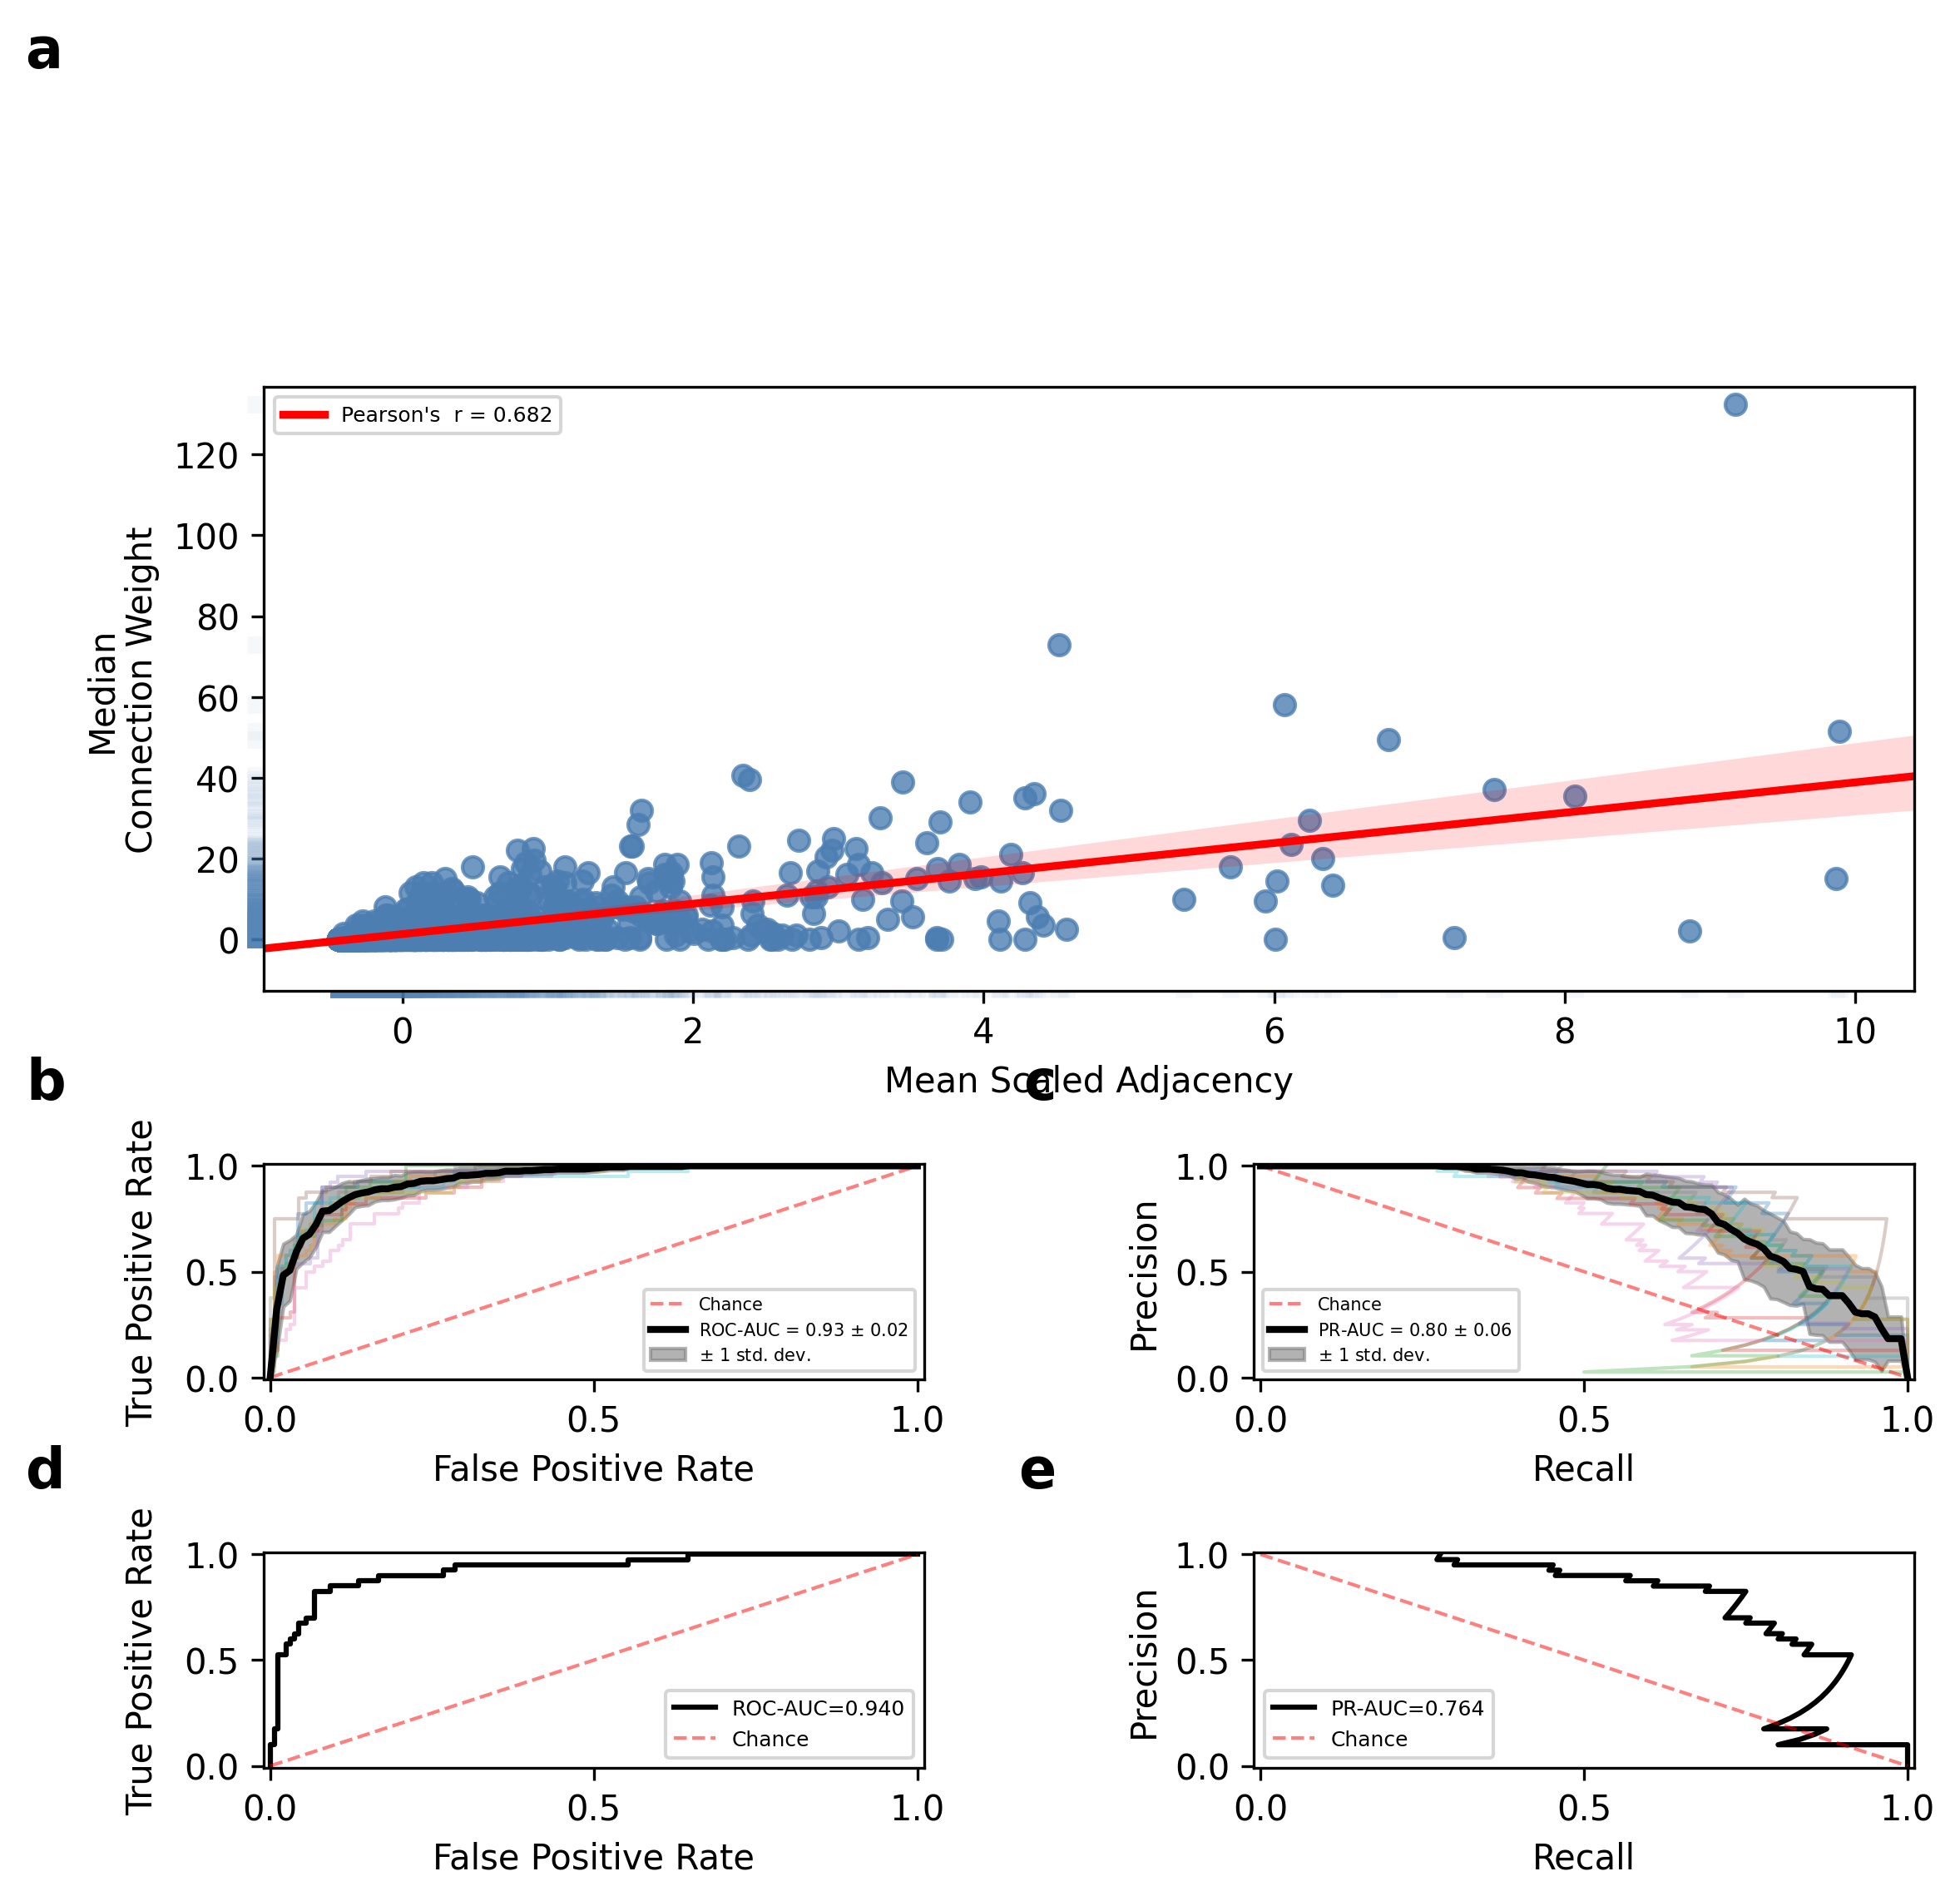

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<Figure size 432x288 with 0 Axes>

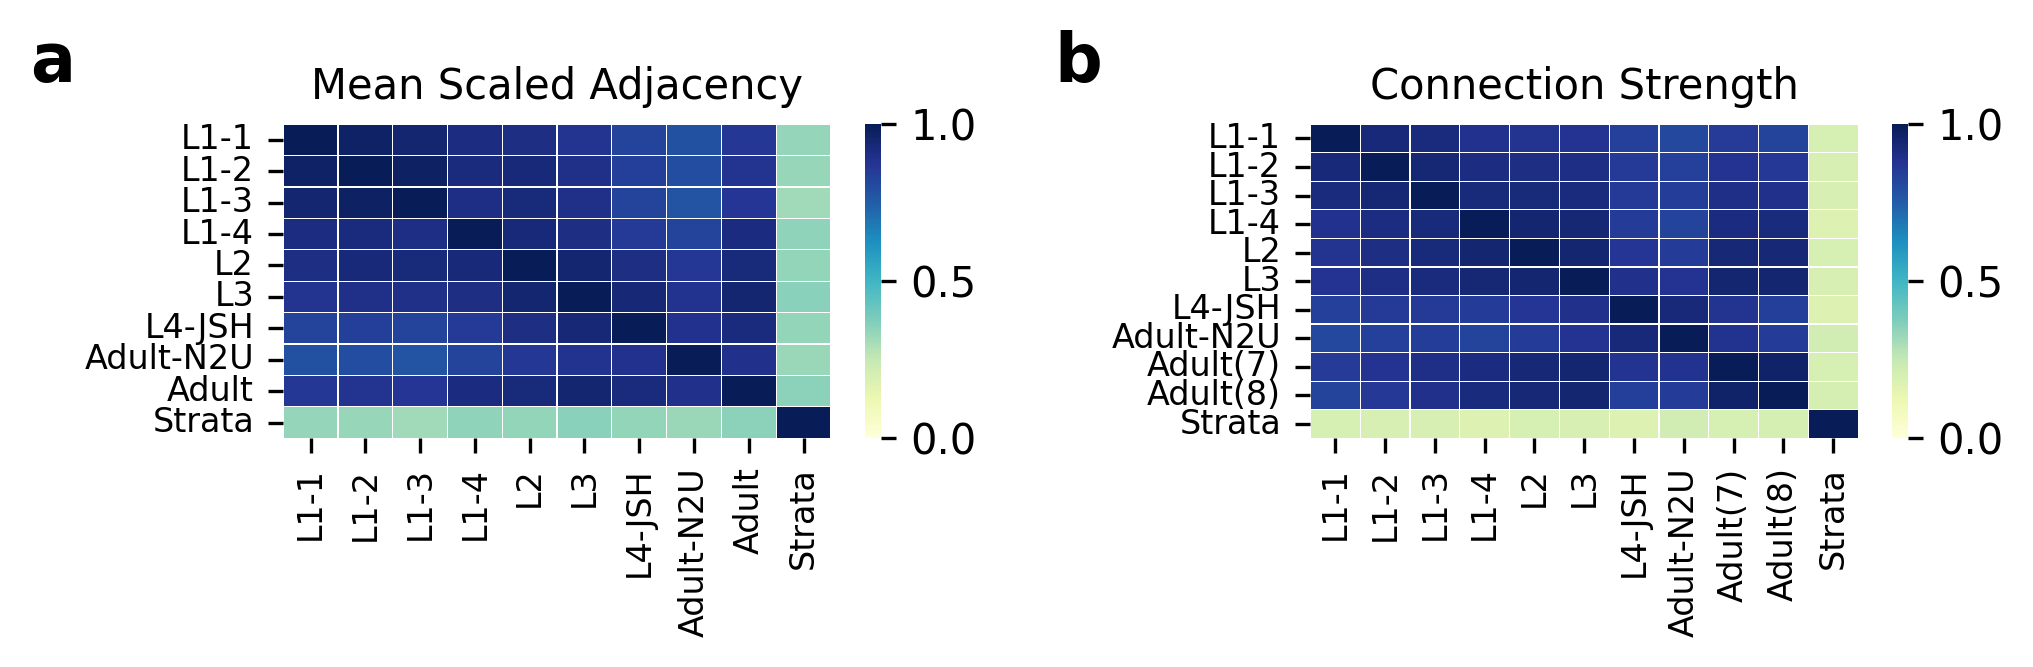

In [ ]:
########## Figure 3############
df_no_zeros = df_concat[df_concat['conserved_y']>2]
print(df_no_zeros['conserved_y'])
print(df_concat['conserved_y'])
#plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

# two rows, two columns, first cell
plt.clf()
fig2 = plt.figure(figsize=(8, 8))
fig2.set_dpi(300)
fig2ax1 = fig2.add_subplot(4,2,(1,4))
plt.rcParams["font.family"] = "sans-serif"
#fig2ax1 = fig2.add_subplot(4,2,1)

#correlation calculations for fig2ax1
corr1,corr1a = stats.pearsonr(df_concat['ave_scaled_adjacency'], df_concat['new_ave_synapse'])
sns.regplot(ax=fig2ax1, x=df_concat.ave_scaled_adjacency, y=df_concat.new_ave_synapse,  color="#4C7EB2", truncate=False, line_kws={"color": "red"})
sns.rugplot(ax=fig2ax1, x=df_concat.ave_scaled_adjacency, y=df_concat.new_ave_synapse,  color="#4C7EB2", lw=5, alpha=.05, height=-.01, clip_on=False)
fig2ax1.set_xlabel('Mean Scaled Adjacency')
fig2ax1.set_ylabel('Median\nConnection Weight')
fig2ax1.legend(labels=["Pearson's  r = "+ str(corr1)[:5]], fontsize=6)
fig2ax1.text(-.122, 1.6, 'a', transform=fig2ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
print('Fig A: pearsons r = ' + str(corr1))
print('Fig A: p-value = ' + str(corr1a))

# Plotting decision regions


# sup_fig1 = plt.figure(figsize=(6, 3))

fig2ax3 = fig2.add_subplot(4,2,5)
fig2ax4 = fig2.add_subplot(4,2,6)
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
X_train_res = X_train.to_numpy()
y_train_res = y_train.to_numpy()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
recalls = []
praucs = []
mean_precision = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_train_res, y_train_res):
    smote_nc = SMOTENC(categorical_features=[1,2], random_state=1)
    X_train_res, y_train_res = smote_nc.fit_resample(X_train_res, y_train_res)
    probas_ = classifier.fit(X_train_res[train], y_train_res[train]).predict_proba(X_train_res[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y_train_res[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    fig2ax3.plot(fpr, tpr, lw=1, alpha=0.3) #,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Compute PR curve and area the curve
    precision, recall, thresholds = precision_recall_curve(y_train_res[test], probas_[:, 1])
    recalls.append(np.interp(mean_fpr, precision, recall))
    recalls[-1][0] = 1.0
    pr_auc = auc(recall, precision)
    praucs.append(pr_auc)
    fig2ax4.plot(precision, recall, lw=1, alpha=0.3) #label='PR fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

fig2ax3.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
fig2ax3.plot(mean_fpr, mean_tpr, color='k', label=r'ROC-AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc), lw=2, alpha=1.0)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
fig2ax3.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.6, label=r'$\pm$ 1 std. dev.')
fig2ax3.set_xlim([-0.01, 1.01])
fig2ax3.set_ylim([-0.01, 1.01])
fig2ax3.set_yticks([0,0.50,1.0])
fig2ax3.set_xticks([0,0.50,1.0])
fig2ax3.set_xlabel('False Positive Rate')
fig2ax3.set_ylabel('True Positive Rate')
fig2ax3.legend(loc="lower right", prop={'size': 5})
fig2ax3.text(-.3, 1.5, 'b', transform=fig2ax3.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig2ax4.plot([0, 1], [1, 0], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
mean_recall = np.mean(recalls, axis=0)
mean_recall[-1] = 0
mean_prauc = auc(mean_precision, mean_recall)
std_prauc = np.std(praucs)
fig2ax4.plot(mean_precision, mean_recall, color='k', label=r'PR-AUC = %0.2f $\pm$ %0.2f' % (mean_prauc, std_prauc), lw=2, alpha=1.0)
std_recall = np.std(recalls, axis=0)
recalls_upper = np.minimum(mean_recall + std_recall, 1)
recalls_lower = np.maximum(mean_recall - std_recall, 0)
fig2ax4.fill_between(mean_precision, recalls_lower, recalls_upper, color='grey', alpha=.6, label=r'$\pm$ 1 std. dev.')
fig2ax4.set_xlim([-0.01, 1.01])
fig2ax4.set_ylim([-0.01, 1.01])
fig2ax4.set_yticks([0,0.50,1.0])
fig2ax4.set_xticks([0,0.50,1.0])
fig2ax4.set_xlabel('Recall')
fig2ax4.set_ylabel('Precision')
fig2ax4.legend(loc="lower left", prop={'size': 5})
fig2ax4.text(-.3, 1.5, 'c', transform=fig2ax4.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig2ax5 = fig2.add_subplot(4,2,7)
fig2ax5.plot(fpr,tpr,label="ROC-AUC="+str(auc_ROC), color='k')
fig2ax5.set_xlabel('False Positive Rate')
fig2ax5.set_ylabel('True Positive Rate')
fig2ax5.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig2ax5.legend(loc=4, prop={'size': 6})
fig2ax5.set_xlim([-0.01, 1.01])
fig2ax5.set_ylim([-0.01, 1.01])
fig2ax5.set_xticks([0,0.50,1.0])
fig2ax5.text(-.3, 1.5, 'd', transform=fig2ax5.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig2ax6 = fig2.add_subplot(4,2,8)
fig2ax6.plot(precision,recall,label="PR-AUC="+str(auc_precision_recall), color='k')
fig2ax6.set_xlabel('Recall')
fig2ax6.set_ylabel('Precision')
fig2ax6.plot([0, 1], [1, 0], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig2ax6.legend(loc=3, prop={'size': 6})
fig2ax6.set_xlim([-0.01, 1.01])
fig2ax6.set_ylim([-0.01, 1.01])
fig2ax6.set_yticks([0,0.50,1.0])
fig2ax6.set_xticks([0,0.50,1.0])
fig2ax6.text(-.3, 1.5, 'e', transform=fig2ax6.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig2.align_ylabels()
fig2.tight_layout()
fig2.subplots_adjust(wspace=0.5, hspace=0.8) 
#plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/manuscript_fig3.svg")
#plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/pngs/manuscript_fig3.png")
#not plotted due to slight illustrator alignment changes
plt.show()





##supplemental figure with heamaps##
plt.clf()
fig2sup1 = plt.figure(figsize=(7, 7))
fig2sup1.set_dpi(300)


fig2sup1ax2 = fig2sup1.add_subplot(4,2,3)
corrmap = df_concat[['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S','brittin_bool_1']]
heatmap_cols = ['L1-1', 'L1-2', 'L1-3', 'L1-4', 'L2', 'L3', 'L4-JSH', 'Adult-N2U', 'Adult', 'Strata']
corrmap.rename(columns=dict(zip(corrmap.columns[[0,1,2,3,4,5,6,7,8,9]], heatmap_cols)),inplace=True)
heatmapmatrix = corrmap.corr()
sns.heatmap(ax=fig2sup1ax2, data=heatmapmatrix, cmap="YlGnBu", yticklabels=True, xticklabels = True, vmin=0, vmax=1, linewidths=0.05)
fig2sup1ax2.set_title('Mean Scaled Adjacency', fontsize=10)
fig2sup1ax2.tick_params(axis='x', labelsize= 8)
fig2sup1ax2.tick_params(axis='y', labelsize= 8)
# plt.colorbar(ax = fig2sup1ax2, shrink = .5)
fig2sup1ax2.text(-.38, 1.3, 'a', transform=fig2sup1ax2.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')

fig2sup1ax7 = fig2sup1.add_subplot(4,2,4)
corrmap2 = df_concat[['witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'jsh_syn', 'n2u_syn', 'witvliet_7_syn', 'witvliet_8_syn', 'brittin_bool_1']]
heatmap_cols2 = ['L1-1', 'L1-2', 'L1-3', 'L1-4', 'L2', 'L3', 'L4-JSH', 'Adult-N2U', 'Adult(7)', 'Adult(8)', 'Strata']
corrmap2.rename(columns=dict(zip(corrmap2.columns[[0,1,2,3,4,5,6,7,8,9,10]], heatmap_cols2)),inplace=True)
heatmapmatrix2 = corrmap2.corr()
sns.heatmap(ax=fig2sup1ax7, data=heatmapmatrix2, cmap="YlGnBu", yticklabels=True, vmin=0, vmax=1, linewidths=0.05)
fig2sup1ax7.set_title('Connection Strength', fontsize=10)
fig2sup1ax7.tick_params(axis='x', labelsize= 8)
fig2sup1ax7.tick_params(axis='y', labelsize= 8)
fig2sup1ax7.text(-.38, 1.3, 'b', transform=fig2sup1ax7.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')



fig2sup1.align_ylabels()
fig2sup1.tight_layout()
fig2sup1.subplots_adjust(wspace=0.5, hspace=0.8) 
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/manuscript_fig3_sup1.svg")
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/pngs/manuscript_fig3_sup1.png")
plt.show()



Pharyngeal model evaluation

spearman's r for ave scaled adjacency and new_ave_synapse 0.6039803709569107 7.0126328924925565e-16
pearson's r for ave scaled adjacency and new_ave_synapse 0.7342023346636123 5.45190110148168e-26
              precision    recall  f1-score   support

           0       0.41      0.91      0.56        44
           1       0.92      0.43      0.59       102

    accuracy                           0.58       146
   macro avg       0.66      0.67      0.58       146
weighted avg       0.76      0.58      0.58       146



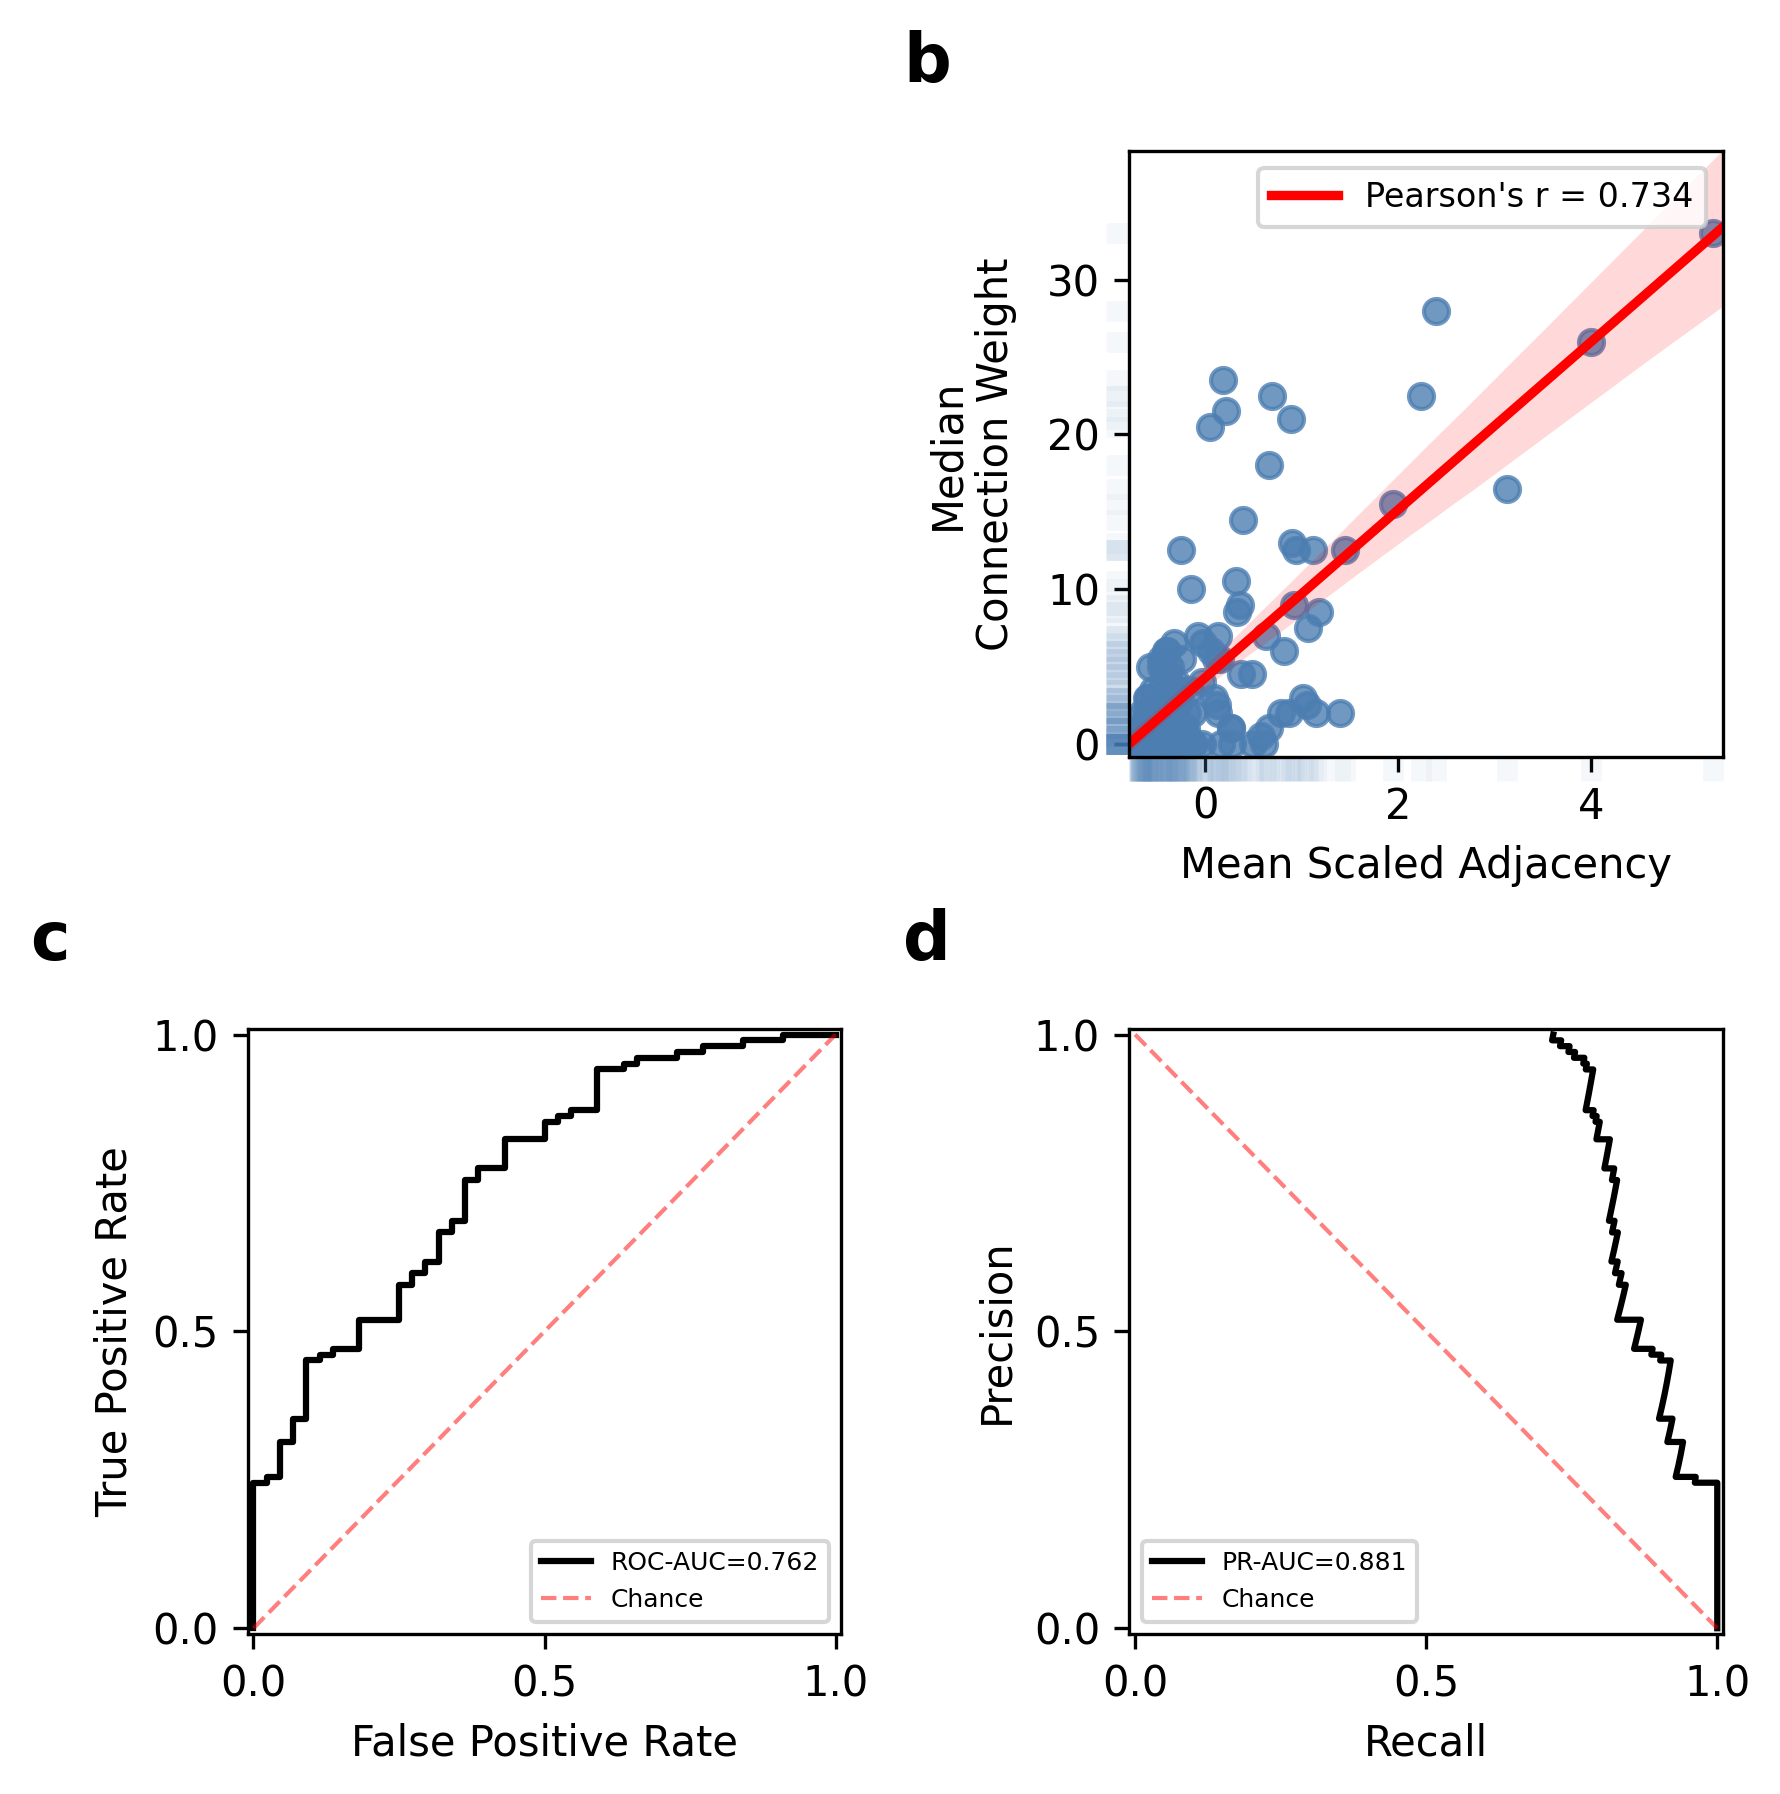

In [ ]:
#import dfs from the compare syn and edge cell##

def synapse_recode(X):
  if X >0:
    return 1
  else:
    return 0

DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency_working/input/'
os.chdir(DIRECTORY_CHOOSE)
adj, syn = pd.read_csv('df_merged_pharynx_adj_ml_full.csv'), pd.read_csv('df_merged_pharynx_syn_ml_full.csv')
df_merged_pharynx = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), [adj,syn])
new_cols = ['jsa_adj', 'n2w_adj', 'synaptic_weight']
df_merged_pharynx.rename(columns=dict(zip(df_merged_pharynx.columns[[3,4,8]], new_cols)),inplace=True)

#construct new columns to measure the average synaptic size. 
df_merged_pharynx['dummy_size'] = df_merged_pharynx['synaptic_weight'].apply(synapse_recode)



#droplist includes SAB because Moyle and Brittin don't analyze. It's not a NR neuron. If a neuron is in one of two datasets, it becomes unclassified in the other.

droplist = ['unk', 'BWM', 'VA01', 'VB01', 'VB02', 'VC01', 'VD01', 'SAB', 'CAN', 'unknownFLPR', 'PVD', 'HSN', 'VA', 'VB', 'Fragment1', 'Fragment2', 'Fragment3', 'Fragment4', 'excgl', 'DB', 'DA', 'excduct']
df_merged_pharynx = df_merged_pharynx[~df_merged_pharynx.pre.isin(droplist)]
df_merged_pharynx = df_merged_pharynx[~df_merged_pharynx.post.isin(droplist)]


#scale and rename the adjacency columns
scaler = StandardScaler()
new_cols1 = ['jsa_adj-s', 'n2w_adj-s']
df_scale = pd.DataFrame(scaler.fit_transform(df_merged_pharynx.iloc[:,3:5]))
df_scale.rename(columns=dict(zip(df_scale.columns[[0,1]], new_cols1)),inplace=True)
df_scale['ave_scaled_adjacency'] = df_scale[['jsa_adj-s', 'n2w_adj-s']].mean(axis=1)



#concatenate dfs
df_concat_pharynx = pd.concat([df_merged_pharynx, df_scale.set_index(df_merged_pharynx.index)], axis=1)
df_concat_pharynx['pre_brittin'] = df_concat_pharynx.apply(lambda x: brittin_layers(x['pre']), axis=1)
df_concat_pharynx['post_brittin'] = df_concat_pharynx.apply(lambda x: brittin_layers(x['post']), axis=1)
df_concat_pharynx['pre_moyle'] = df_concat_pharynx.apply(lambda x: moyle_layers(x['pre']), axis=1)
df_concat_pharynx['post_moyle'] = df_concat_pharynx.apply(lambda x: moyle_layers(x['post']), axis=1)
df_concat_pharynx['brittin_strata'] = df_concat_pharynx.apply(lambda x: ganglia_check(x['pre_brittin'], x['post_brittin']), axis=1)
df_concat_pharynx['moyle_strata'] = df_concat_pharynx.apply(lambda x: ganglia_check(x['pre_moyle'], x['post_moyle']), axis=1)
df_concat_pharynx.fillna(0, inplace=True) 


#make dummy columns for the categorical predictors
categorical_cols = ['pre_brittin', 'post_brittin', 'pre_moyle', 'post_moyle', 'brittin_strata', 'moyle_strata']
df_concat_pharynx[['brittin_bool_1', 'brittin_bool_2']] = 1,0
df_concat_pharynx.to_csv('/content/drive/MyDrive/cook_adjacency_working/figures/sup_2_pharynx_modeling.csv')

#set variables for modeling
X_scale_pharynx = df_concat_pharynx[['ave_scaled_adjacency', 'brittin_bool_1', 'brittin_bool_2']]
Y_pharynx = df_concat_pharynx.dummy_size
Y_pharynx.fillna(0, inplace=True)
Y_pharynx = Y_pharynx.astype('int')

###correlations###

rho, pval = stats.spearmanr(df_concat_pharynx.ave_scaled_adjacency, df_concat_pharynx.average_size_y)
print("spearman's r for ave scaled adjacency and new_ave_synapse", rho, pval)

rho, pval = stats.pearsonr(df_concat_pharynx.ave_scaled_adjacency, df_concat_pharynx.average_size_y)
print("pearson's r for ave scaled adjacency and new_ave_synapse", rho, pval)



#test final model on the pharynx

full_predictions = logreg_final.predict(X_scale_pharynx)
print(classification_report(Y_pharynx,full_predictions))

y_pred_proba_p = logreg_final.predict_proba(X_scale_pharynx)[::,1]
fpr, tpr, threshold = metrics.roc_curve(Y_pharynx, y_pred_proba_p)
precision, recall, threshold = precision_recall_curve(Y_pharynx, y_pred_proba_p)
auc_ROC = str(metrics.roc_auc_score(Y_pharynx, y_pred_proba_p))[:5]
auc_precision_recall = str(metrics.auc(recall, precision))[:5]


plt.rcParams["font.family"] = "sans-serif"
fig3 = plt.figure(figsize=(6, 6))
fig3.set_dpi(300)



# two rows, two colums
fig3ax1 = fig3.add_subplot(2,2,2)
corr_pharynx,_ = stats.pearsonr(df_concat_pharynx['ave_scaled_adjacency'], df_concat_pharynx['average_size_y'])
sns.regplot(ax=fig3ax1, x=df_concat_pharynx.ave_scaled_adjacency, y=df_concat_pharynx.average_size_y,  color="#4C7EB2", truncate=False, line_kws={"color": "red"})
sns.rugplot(ax=fig3ax1, x=df_concat_pharynx.ave_scaled_adjacency, y=df_concat_pharynx.average_size_y,  color="#4C7EB2", lw=5, alpha=.05, height=-.04, clip_on=False)
fig3ax1.set_xlabel('Mean Scaled Adjacency')
fig3ax1.set_ylabel('Median\nConnection Weight')
fig3ax1.legend(labels=["Pearson's r = " + str(corr_pharynx)[:5]], fontsize=8)
fig3ax1.text(-.3, 1.2, 'b', transform=fig3ax1.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig3ax3 = fig3.add_subplot(2,2,3)
fig3ax3.plot(fpr,tpr,label="ROC-AUC="+str(auc_ROC), color='k')
fig3ax3.set_xlabel('False Positive Rate')
fig3ax3.set_ylabel('True Positive Rate')
fig3ax3.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig3ax3.legend(loc=4, prop={'size': 6})
fig3ax3.set_xlim([-0.01, 1.01])
fig3ax3.set_ylim([-0.01, 1.01])
fig3ax3.set_yticks([0,0.50,1.0])
fig3ax3.set_xticks([0,0.50,1.0])
fig3ax3.text(-.3, 1.2, 'c', transform=fig3ax3.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')


fig3ax4 = fig3.add_subplot(2,2,4)
fig3ax4.plot(precision,recall,label="PR-AUC="+str(auc_precision_recall), color='k')
fig3ax4.set_xlabel('Recall')
fig3ax4.set_ylabel('Precision')
fig3ax4.plot([0, 1], [1, 0], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig3ax4.legend(loc=3, prop={'size': 6})
fig3ax4.set_xlim([-0.01, 1.01])
fig3ax4.set_ylim([-0.01, 1.01])
fig3ax4.set_yticks([0,0.50,1.0])
fig3ax4.set_xticks([0,0.50,1.0])
fig3ax4.text(-.3, 1.2, 'd', transform=fig3ax4.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')



fig3.align_ylabels()
fig3.subplots_adjust(wspace=0.5, hspace=0.8) 
fig3.tight_layout()
plt.savefig("/content/drive/MyDrive/cook_adjacency_working/figures/manuscript_fig4_pharynx.svg")
#not plotted due to small addition in illustrator
plt.show()





